In [1]:
***REMOVED***
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf


physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(
 #   physical_devices[0], True
#)
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-30 22:49:15.761624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 22:49:15.761688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 22:49:15.807421: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 22:49:15.908147: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 22:49:17.207722: W tensorflow/compiler/tf2

In [2]:
df = pd.read_csv("../tags_processed_stages/dafre_tags.csv")
num_classes = df['tags_cat4'].nunique()
print(num_classes)

3486


In [3]:
len(df)

463437

In [4]:

class_counts = df['tags_cat4'].value_counts()
df_filtered = df[df['tags_cat4'].isin(class_counts[class_counts >= 2].index)]
train_df, temp_df = train_test_split(df_filtered, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

common_classes = set(train_df['tags_cat4']).intersection(set(val_df['tags_cat4']), set(test_df['tags_cat4']))

train_df = train_df[train_df['tags_cat4'].isin(common_classes)]
val_df = val_df[val_df['tags_cat4'].isin(common_classes)]
test_df = test_df[test_df['tags_cat4'].isin(common_classes)]
print(val_df['tags_cat4'].nunique())

3095


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='../fullMin256/', 
    x_col='dir', 
    y_col='tags_cat4', 
    target_size=(150, 150), 
    batch_size=64,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='../fullMin256/',
    x_col='dir',
    y_col='tags_cat4',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='../fullMin256/',
    x_col='dir',
    y_col='tags_cat4',
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 366503 validated image filenames belonging to 3095 classes.
Found 46064 validated image filenames belonging to 3095 classes.
Found 46028 validated image filenames belonging to 3095 classes.


In [22]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False  

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3095, activation='softmax')
])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6, mode='min', verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1,
    steps_per_epoch=len(train_generator)/16,  
    validation_steps=len(validation_generator)/16, 
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalFocalCrossentropy(), metrics=['accuracy'])
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10, 
    verbose=1,
    steps_per_epoch=len(train_generator)/16,
    validation_steps=len(validation_generator)/16,
    callbacks=[checkpoint, early_stopping, reduce_lr])  


base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss=tf.keras.losses.CategoricalFocalCrossentropy(),
              metrics=['accuracy'])


fine_tune_epochs = 10  
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    verbose=1,
    steps_per_epoch=len(train_generator)/16,
    validation_steps=len(validation_generator)/16,
    callbacks=[checkpoint, early_stopping, reduce_lr]) 


Epoch 1/20
715/715 [==============================] - 81s 113ms/step - loss: 1.9695 - accuracy: 0.0540 - val_loss: 1.8340 - val_accuracy: 0.0802 - lr: 0.0010
Epoch 2/20
715/715 [==============================] - 83s 116ms/step - loss: 1.8786 - accuracy: 0.0563 - val_loss: 1.7612 - val_accuracy: 0.0684 - lr: 0.0010
Epoch 3/20
715/715 [==============================] - 88s 123ms/step - loss: 1.8266 - accuracy: 0.0571 - val_loss: 1.7313 - val_accuracy: 0.0701 - lr: 0.0010
Epoch 4/20
334/715 [============>.................] - ETA: 41s - loss: 1.8004 - accuracy: 0.0581

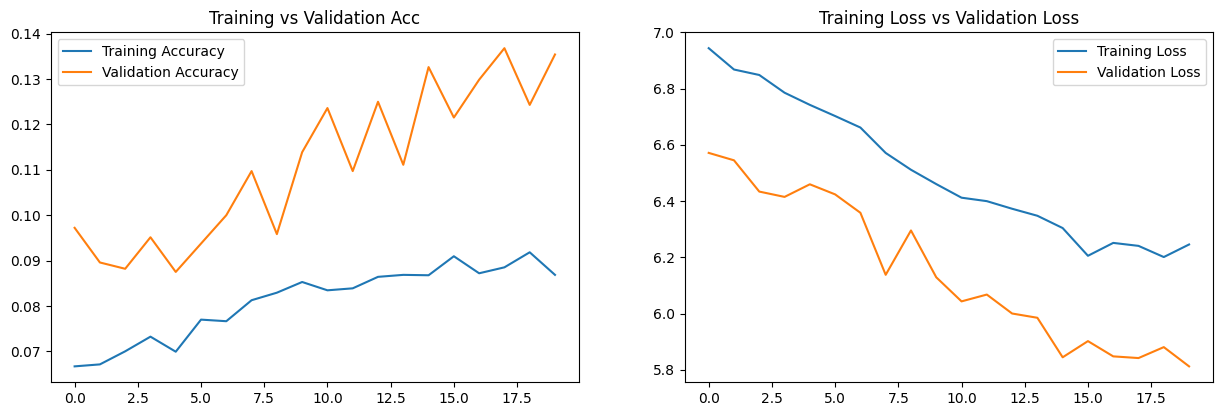

In [19]:
import matplotlib.pyplot as plt

tra_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(tra_acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Training vs Validation Acc")

tra_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.subplot(2,2,2)
plt.plot(tra_loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.title("Training Loss vs Validation Loss")
plt.show()